### Hierarchical Principal Components Analysis

계층적 PCA(Hierarchical PCA)는 대규모 또는 복잡한 데이터 세트를 효과적으로 분석하기 위한 방법이다. 이 접근법은 데이터를 여러 서브셋으로 분할한 후 각 서브셋에 대해 주성분 분석(PCA)을 별도로 수행한다

Subset별로 PCA를 통해 각 서브셋의 주요 패턴과 구조를 추출하며, 이후 이러한 결과를 종합하여 전체 데이터 세트의 특성을 파악한다. 계층적 PCA는 대규모 데이터 세트를 다루는 데 있어 계산상의 부담을 줄이고, 서브셋 간의 다양한 관계나 특성을 더 깊이 이해할 수 있다는 것이 장점이다 이 방법은 복잡한 구조를 가진 데이터 세트를 세분화하여 분석하는 데 특히 유용하며, 금융 분야에서 주로 쓰이고 있다. 그러나 계층적 PCA는 전체 데이터에 대한 일반적인 PCA와 다른 결과를 줄 가능성이 크기 때문에, 분석 결과 해석 시 데이터 분할 방식과 Subset의 특성을 모두 고려해야 한다

계층적 PCA에는 다음과 같은 단계로 이뤄진다

1. 트리 군집화
2. 준 대각화(Quasi-Diagonalization)
3. 재귀적 이분법

이번절에서는 계층적 군집화를 통해 금융 시계열에서 자산의 배분이 어떻게 이루어지는지 보도록 한다

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier
import yfinance as yf
import warnings 
warnings.filterwarnings("ignore")

TICKERS = ['AAPL','GOOGL','XOM','WMT','V','NVDA','JPM','F']
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS, 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']
ret = data.pct_change().dropna()

#### 1. 트리 군집화

관측값 $X$의 $T \times N$행렬을 고려해 보자. 행렬은 $T$기간에 대한 $N$개 변수 계열이다. 이 $N$ 열벡터를 군집의 계층 구조로 병합해 배분을 트리 그래프를 따라 하향식으로 흘러내리고자 한다

첫째, 원소가 $\rho = \{\rho_{i,j}\}_{i,j = 1, \dots, N}$인 $N \times N$ 상관관계 행렬을 계산한다. 여기서 $\rho_{i,j} = \rho [X_i, X_j]$다. 거리 척도는 $d : (X_i, X_j) \subset B \rightarrow \mathbb{R} \in [0,1], d_{i,j} = d[X_i, X_j] = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}$로 정의되며, 여기서 $B = [1,\dots, i, \dots, N]$내의 원소의 카티시안 곱이다. 이는 $N \times N$ 거리 행렬 $D = \{d_{i,j}\}_{i,j = 1, \dots, N}$을 계산할 수 있게 해준다. 행렬 $D$는 다음과 같은 성질을 갖는다

$$d[x, y] \geq 0$$
$$d[x,y] = 0 \Leftrightarrow X = Y$$
$$d[x,y] = d[Y,X]$$
$$d[X,Z] \geq d[x,y] + d[Y,Z]$$

따라서, 행렬 $D$는 적절한 거리 공간이라고 할 수 있다

In [7]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform

cov, corr = data.cov(), data.corr()
dist = np.sqrt((1 - corr) / 2) # distance matrix
link = sch.linkage(squareform(dist), method = 'single') # linkage matrix

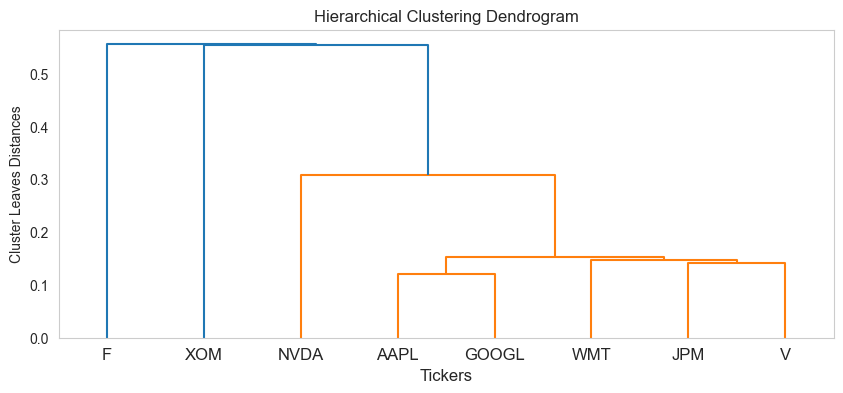

In [8]:
columns = data.columns
plt.figure(figsize = (10, 4))
dendrogram(link, labels=columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances')
plt.grid(False)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

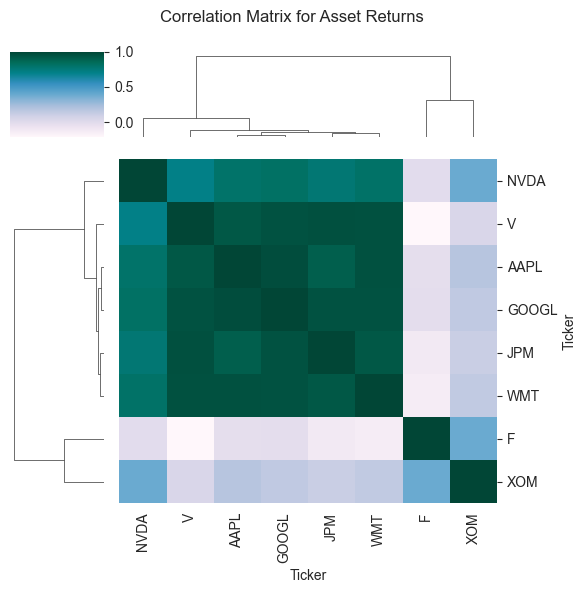

In [9]:
g = sns.clustermap(corr, figsize = (6, 6), cmap = 'PuBuGn')
g.fig.suptitle('Correlation Matrix for Asset Returns')
plt.tight_layout()
plt.show()

#### 2. 준 대각화

이 단계는 공분산 행렬의 행과 열을 재구성해 가장 큰 값이 대각선에 위치하게 한다. 공분산의 준대각화는 유용한 속성이다

유사한 금융 상품은 함께 배치되고 다른 상품은 서로 떨어뜨리도록 배치한다. 알고리즘은 아래의 코드와 같이 작동하는데, 연결 행렬의 각 행이 두 branch를 하나로 합친다는 것을 알고 있다. 가지 내의 군집들을 그 구성 성분으로 재귀적으로 교체하여, 군집이 더이상 남지 않을 때까지 반복한다. 이런 교체는 군집화의 순서를 유지하게 하는데, 출력은 군집화되지 않은 원소의 정렬된 리스트이다. 아래의 예제를 통해 준 대각화에 대해서 간단히 살펴보자

In [10]:
def QuasiDiag(link: np.ndarray) -> list:
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]    # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)    # make space
        df0 = sortIx[sortIx >= numItems]    # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]    # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = pd.concat([sortIx, df0])    # item 2
        sortIx = sortIx.sort_index()    # re-sort
        sortIx.index = range(sortIx.shape[0])    # re-index
    lst =  sortIx.tolist()
    return lst

In [11]:
print(QuasiDiag(link)) # 준 대각화된 성분의 index

[1, 7, 4, 0, 2, 6, 3, 5]


#### 3. 재귀적 이분법

2를 통해 준대각 행렬을 얻었다. 역분산 배분은 대각 공분산 행렬에 대해 최적이다. 이 사실들로부터 두 가지 활용이 가능하다

1. 상향식 : 연속된 부분 집합의 분산을 역분산 배분의 분산으로 정의한다
2. 하향식 : 인접한 부분 집합 간의 배분을 이들의 총 분산에 역으로 비례하도록 분할한다. 아래의 알고리즘은 하향식 아이디어를 공식화한다

In [12]:
def InversePortfolio(cov, **kargs) : 
    ivp = 1 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ClusterVar(cov, cItems) :
    cov_ = pd.DataFrame(cov).loc[cItems, cItems] # 행렬 분할
    w_ = InversePortfolio(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def RecBipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    w = pd.Series([1] * len(sortIx), index=sortIx)
    cItems = [sortIx]    # 모든 아이템을 하나의 군집으로 초기화
    while len(cItems) > 0:
        cItems = [i[int(j): int(k)] for i in cItems
                  for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = ClusterVar(cov, cItems0)
            cVar1 = ClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [17]:
Ix = QuasiDiag(link)
weights = RecBipart(ret.cov().values, Ix)
weights = pd.Series(
    weights.values,
    index = ret.iloc[:, weights.index].columns,
    name = 'weights'
)

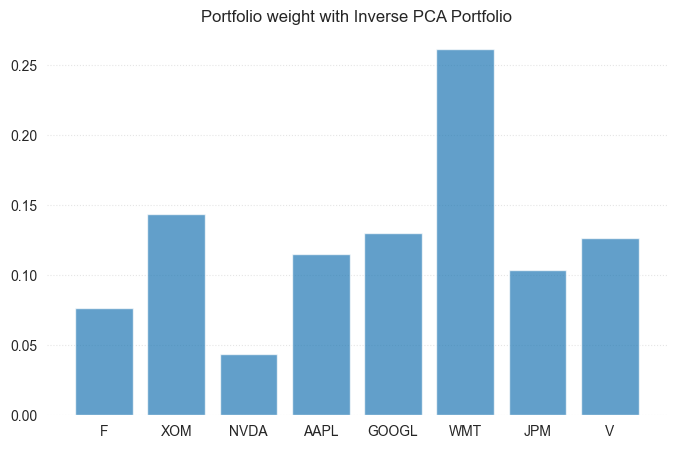

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.bar(
    ret.loc[:, weights.index].columns, 
    weights, 
    alpha = 0.7
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title("Portfolio weight with Inverse PCA Portfolio")
plt.show()